# Setting up a PEST interface from MODFLOW6 using the `PstFrom` class

The `PstFrom` class is a generalization of the prototype `PstFromFlopy` class. The generalization in `PstFrom` means users need to explicitly define what files are to be parameterized and what files contain model outputs to treat as observations.  Two primary types of files are supported:  arrays and lists.  Array files contain a data type (usually floating points) while list files will have a few columns that contain index information and then columns of floating point values.  

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy

An existing MODFLOW6 model is in the directory `freyberg_mf6`.  Lets check it out:

In [4]:
org_model_ws = os.path.join('freyberg_mf6')
os.listdir(org_model_ws)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

You can see that all the input array and list data for this model have been written "externally" - this is key to using the `PstFrom` class. 

Let's quickly viz the model top just to remind us of what we are dealing with:

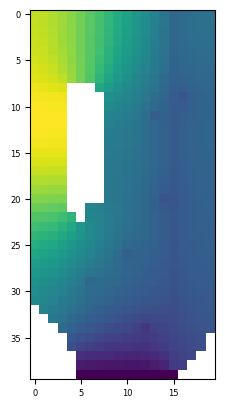

In [5]:
id_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_idomain_layer3.txt"))
top_arr = np.loadtxt(os.path.join(org_model_ws,"freyberg6.dis_top.txt"))
top_arr[id_arr==0] = np.nan
plt.imshow(top_arr)

Now let's copy those files to a temporary location just to make sure we don't goof up those original files:

In [6]:
tmp_model_ws = "temp_pst_from"
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters for build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is not required to use the `PstFrom` class.

In [7]:
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model("freyberg6")


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading solution package freyberg6...


Here we use the simple `SpatialReference` pyemu implements to help us spatially locate parameters

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_model_ws, "freyberg6.nam"),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

Now we can instantiate a `PstFrom` class instance

In [9]:
template_ws = "freyberg6_template"
pf = pyemu.utils.PstFrom(original_d=tmp_model_ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2018")

2023-07-25 20:26:30.843268 starting: opening PstFrom.log for logging
2023-07-25 20:26:30.843268 starting PstFrom process
2023-07-25 20:26:30.844280 starting: setting up dirs
2023-07-25 20:26:30.844280 starting: copying original_d 'temp_pst_from' to new_d 'freyberg6_template'
2023-07-25 20:26:30.915600 finished: copying original_d 'temp_pst_from' to new_d 'freyberg6_template' took: 0:00:00.071320
2023-07-25 20:26:30.916598 finished: setting up dirs took: 0:00:00.072318


## Observations

So now that we have a `PstFrom` instance, but its just an empty container at this point, so we need to add some PEST interface "observations" and "parameters".  Let's start with observations using MODFLOW6 head.  These are stored in `heads.csv`:

In [ ]:
df = pd.read_csv(os.path.join(tmp_model_ws,"heads.csv"),index_col=0)
df

The main entry point for adding observations is (surprise) `PstFrom.add_observations()`.  This method works on the list-type observation output file.  We need to tell it what column is the index column (can be string if there is a header or int if no header) and then what columns contain quantities we want to monitor (e.g. "observe") in the control file - in this case we want to monitor all columns except the index column:

In [ ]:
hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                    use_cols=list(df.columns.values),prefix="hds",)
hds_df

We can see that it returned a dataframe with lots of useful info: the observation names that were formed (`obsnme`), the values that were read from `heads.csv` (`obsval`) and also some generic weights and group names.  At this point, no control file has been created, we have simply prepared to add this observations to the control file later.  

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

Nice!  We also have a PEST-style instruction file for those obs.

Now lets do the same for SFR observations:

In [ ]:
df = pd.read_csv(os.path.join(tmp_model_ws, "sfr.csv"), index_col=0)
sfr_df = pf.add_observations("sfr.csv", insfile="sfr.csv.ins", index_cols="time", use_cols=list(df.columns.values))
sfr_df

Sweet as!  Now that we have some observations, let's add parameters!

## Parameters

In the `PstFrom` realm, all parameters are setup as multipliers against existing array and list files.  This is a good thing because it lets us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. It also let's us use mixtures of spatial and temporal scales in the parameters to account for varying scale of uncertainty. 

Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty.  To do that we need to define "geostatistical structures".  As we will see, defining parameter correlation is optional and only matters for the prior parameter covariance matrix and prior parameter ensemble:

In [ ]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=1000)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')
temporal_gs = pyemu.geostats.GeoStruct(variograms=pyemu.geostats.ExpVario(contribution=1.0,a=60))

In [ ]:
grid_gs.plot()
print("spatial variogram")

In [ ]:
temporal_gs.plot()
"temporal variogram (x axis in days)"

Now let's get the idomain array to use as a zone array - this keeps us from setting up parameters in inactive model cells:

In [ ]:
ib = m.dis.idomain[0].array

First, let's setup parameters for static properties - HK, VK, SS, SY.  Do that, we need to find all the external array files that contain these static arrays.  Let's do just HK slowly so as to explain what is happening:

In [ ]:
hk_arr_files = [f for f in os.listdir(tmp_model_ws) if "npf_k_" in f and f.endswith(".txt")]
hk_arr_files

So those are the existing model input arrays for HK.  Notice we found the files in the temporary model workspace - `PstFrom` will copy all those files to the new model workspace for us in a bit...

Let's setup grid-scale multiplier parameter for HK in layer 1:

In [ ]:
pf.add_parameters(filenames="freyberg6.npf_k_layer1.txt",par_type="grid",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01)


What just happened there?  Well, we told our `PstFrom` instance to setup a set of grid-scale multiplier parameters (`par_type="grid"`) for the array file "freyberg6.npf_k_layer1.txt". We told it to prefix the parameter names with "hk_layer_1" and also to make the parameter group "hk_layer_1" (`pargp="hk_layer_1"`).  When specified two sets of bound information:  `upper_bound` and `lower_bound` are the standard control file bounds, while `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array - since we are using multipliers (and potentially, sets of multipliers - stay tuned), it is important to make sure we keep the resulting model input arrays within the range of realistic values.

If you inspect the contents of the working directory, we will see a new template file:

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

In [ ]:
with open(os.path.join(template_ws,"hk_layer_1_inst0_grid.csv.tpl"),'r') as f:
    for _ in range(2):
        print(f.readline().strip())
        


So those might look like pretty redic parameter names, but they contain heaps of metadata to help you post process things later...

## Pilot points in `PstFrom`

You can add pilot points in two ways `PstFrom` can generate them for you on a regular grid or you can supply `PstFrom` with existing pilot point location information.  First lets looks at the regular simple stuf - when you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10, which is every 10th row and column.  We can override this default like:

In [ ]:
pf.add_parameters(filenames="freyberg6.npf_k_layer3.txt",par_type="pilotpoints",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                   pp_space=5)

Now lets look at how to supply existing pilot locations - to do this, we simply change the `pp_space` arg to a filename or a dataframe.  The dataframe must have "name", "x", and "y" as columns - it can have more, but must have those.  If you supply `pp_space` as an `str` it is assumed to be a filename the extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type) and everything else is assumed to be a pilot points file type. For example, here it is with a shapefile - first we will just make up some random pilot point locations and write those to a shapefile:

In [ ]:
xmn = m.modelgrid.xvertices.min()
xmx = m.modelgrid.xvertices.max()
ymn = m.modelgrid.yvertices.min()
ymx = m.modelgrid.yvertices.max()

numpp = 20
xvals = np.random.uniform(xmn,xmx,numpp)
yvals = np.random.uniform(ymn, ymx, numpp)
pp_locs = pd.DataFrame({"x":xvals,"y":yvals})
pp_locs.loc[:,"zone"] = 1
pp_locs.loc[:,"name"] = ["pp_{0}".format(i) for i in range(numpp)]
pp_locs.loc[:,"parval1"] = 1.0

pyemu.pp_utils.write_pp_shapfile(pp_locs,os.path.join(template_ws,"pp_locs.shp"))

Normally, you would probably put more thought in to pilot point locations, or maybe not!  Now we call `add_parameters` and just pass the shapefile name for `pp_space`:

In [ ]:
pf.add_parameters(filenames="freyberg6.npf_k_layer2.txt",par_type="pilotpoints",
                   par_name_base="hk_layer_1",pargp="hk_layer_1",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                   pp_space="pp_locs.shp")



## Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. For example, let's say you have a post processing function called `process_model_outputs()` in a python source file called `helpers.py`:

In [ ]:
_ = [print(line.rstrip()) for line in open("helpers.py",'r').readlines()]

We see that the file `helpers.py` contains two functions (could be more..).  We want to call `process_model_outputs()` each time pest(++) runs the model as a post processing function.  This function will yield some quantities that we want to record with an instruction.  So, first, we can call the function `write_ins_file()` in `helpers.py` to build the instruction file for the special processed outputs that `process_model_outputs()` will produce (in this trivial example, `process_model_outputs()` just generates random numbers...).  Note that the instruction file needs to be in the `template_ws` directory since it is a pest interface file.

Lets make sure our new instruction file exists...

In [ ]:
assert os.path.exists("special_outputs.dat.ins")
special_ins_filename = os.path.join(template_ws,"special_outputs.dat.ins")
shutil.copy2("special_outputs.dat.ins",special_ins_filename)

First, we can add the function `process_model_outputs()` to the forward run script like this:

In [ ]:
pf.add_py_function("helpers.py","process_model_outputs()",is_pre_cmd=False)

This will copy the function `process_model_outputs()` from `helpers.py` into the forward run script that `PstFrom` will write. But we still need to add the instruction file into the mix - lets do that! 

In [ ]:
out_file = special_ins_filename.replace(".ins","")
pf.add_observations_from_ins(ins_file=special_ins_filename,out_file=out_file,pst_path=".")

that `pst_path` argument tells `PstFrom` that the instruction file will be in the directory where pest(++) is running

### build the control file, pest interface files, and forward run script
At this point, we have some parameters and some observations, so we can create a control file:

In [ ]:
pst = pf.build_pst()

Oh snap! we did it!  thanks for playing...

Well, there is a little more to the story.  Like how do we run this thing? Lucky for you, `PstFrom` writes a forward run script for you! Say Wat?!

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".py")]

In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

Not bad! We have everything we need, including our special post processing function...except we didnt set a command to run the model! Doh!  

Let's add that:

In [ ]:
# only execute this block once!
pf.mod_sys_cmds.append("mf6")
pst = pf.build_pst()


In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

That's better!  See the `pyemu.os_utils.run(r'mf6')` line in `main()`?  

We also see that we now have a function called `process_model_outputs()` added to the forward run script and the function is being called after the model run call.



## Generating geostatistical prior covariance matrices and ensembles

So that's nice, but how do we include spatial correlation in these parameters?  It simple: just pass the `geostruct` arg to `PstFrom.add_parameters()`

In [ ]:
pf.add_parameters(filenames="freyberg6.npf_k_layer3.txt",par_type="grid",
                   par_name_base="hk_layer_3",pargp="hk_layer_3",zone_array=ib,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=100,ult_lbound=0.01,
                 geostruct=grid_gs)


let's also check out the super awesome prior parameter covariance matrix and prior parameter ensemble helpers in `PstFrom`:

In [ ]:
pst = pf.build_pst()
cov = pf.build_prior()
x = cov.x.copy()
x[x<0.00001] = np.NaN
plt.imshow(x)

Da-um!  that's sweet ez!  We can see the first block of HK parameters in the upper left as "uncorrelated" (diagonal only) entries, then the second block of HK parameters (lower right) that are spatially correlated.

### List file parameterization

Let's add parameters for well extraction rates (always uncertain, rarely estimated!)

In [ ]:
wel_files = [f for f in os.listdir(tmp_model_ws) if "wel_stress_period" in f and f.endswith(".txt")]
wel_files

In [ ]:
pd.read_csv(os.path.join(tmp_model_ws,wel_files[0]),header=None)

There are several ways to approach wel file parameterization.  One way is to add a constant multiplier parameter for each stress period (that is, one scaling parameter that is applied all active wells for each stress period).  Let's see how that looks, but first one important point:  If you use the same parameter group name (`pargp`) and same geostruct, the `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the well multiplier pars, so we use the same parameter group names, specify the `datetime` and `geostruct` args.

In [ ]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
dts = pd.to_datetime(pf.start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

for wel_file in wel_files:
    # get the stress period number from the file name
    kper = int(wel_file.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=wel_file,par_type="constant",par_name_base="wel_cn",
                     pargp="wel_cn", upper_bound = 1.5, lower_bound=0.5,
                     datetime=dts[kper],geostruct=temporal_gs)

In [ ]:
pst = pf.build_pst()
cov = pf.build_prior(fmt="none") # skip saving to a file...
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x)

See the little offset in the lower right?  there are a few parameters there in a small block:

In [ ]:
plt.imshow(x[-25:,-25:])

Those are our constant-in-space but correlated in time wel rate parameters - snap!

To compliment those stress period level constant multipliers, lets add a set of multipliers, one for each pumping well, that is broadcast across all stress periods (and let's add spatial correlation for these):

In [ ]:
pf.add_parameters(filenames=wel_files,par_type="grid",par_name_base="wel_gr",
                     pargp="wel_gr", upper_bound = 1.5, lower_bound=0.5,
                  geostruct=grid_gs)

In [ ]:
pst = pf.build_pst()
cov = pf.build_prior(fmt="none")
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

The upper left block is the constant-in-space but correlated-in-time wel rate multiplier parameters, while the lower right block is the constant-in-time but correlated-in-space wel rate multiplier parameters.  Boom!

## After building the control file

At this point, we can do some additional modifications that would typically be done that are problem specific.  Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

### Additional parameters in existing template files

In many cases, you will have additional odd-ball parameters that arent in list or array file format that you want to include in the pest control.  To demonstrate how this works, lets make up a template file:

In [ ]:
tpl_filename = os.path.join(template_ws,"special_pars.dat.tpl")
with open(tpl_filename,'w') as f:
    f.write("ptf ~\n")
    f.write("special_par1  ~  special_par1   ~\n")
    f.write("special_par2  ~  special_par2   ~\n")

In [ ]:
pf.pst.add_parameters(tpl_filename,pst_path=".")

### Tying parameters

Let's say you want to tie some parameters in the control file.  This happens through the `Pst.parameter_data` dataframe.  Here let's tie the first parameter in the control file to the second:

In [ ]:
par = pf.pst.parameter_data
par.loc[pf.pst.par_names[0],"partrans"] = "tied"
par.loc[pf.pst.par_names[0],"partied"] = pf.pst.par_names[1]

### Manipulating parameter bounds

While you can pass parameter bound information to `PstFrom.add_parameters()`, in many cases, you may want to change the bounds for individual parameters before build the prior parameter covariance matrix and/or generating the prior parameter ensemble.  This can be done through the `PstFrom.pst.parameter_data` dataframe:

In [ ]:
par.loc[pf.pst.par_names[5:10],"parlbnd"]

In [ ]:
par.loc[pf.pst.par_names[5:10],"parlbnd"] = 0.25
par.loc[pf.pst.par_names[5:10],"parlbnd"]

### Setting observation values and weights

So far, we have automated the setup for pest(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  `PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  However, if you have actual observation data and you want to use pest(++) to try to match these data, then you need to get these values into the `* observation data` section and you will probably also need to adjust the `weight` quantities as well.  You can do this operation with `pandas` or you can save the control file in "version 2" format, which will write the `* observation data` section (along with the sections) as a CSV file, which can be imported into any number of spreadsheet programs.  

# Generating a prior parameter ensemble

This is crazy easy - using the previous defined correlation structures, we can draw from the block diagonal covariance matrix (and use spectral simulation for the grid-scale parameters):

In [ ]:
pe = pf.draw(num_reals=100,use_specsim=True)

In [ ]:
pe.to_csv(os.path.join(template_ws,"prior.csv"))

In [ ]:
print(pe.loc[:,pst.adj_par_names[0]])
pe.loc[:,pst.adj_par_names[0]]._df.hist()

# Industrial strength control file setup

This functionality mimics the demonstration the `PstFrom` manuscript

In [ ]:
# load the mf6 model with flopy to get the spatial reference
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model("freyberg6")

# work out the spatial rediscretization factor
redis_fac = m.dis.nrow.data / 40

# where the pest interface will be constructed
template_ws = tmp_model_ws.split('_')[1] + "_template"


# instantiate PstFrom object
pf = pyemu.utils.PstFrom(original_d=tmp_model_ws, new_d=template_ws,
             remove_existing=True,
             longnames=True, spatial_reference=m.modelgrid,
             zero_based=False,start_datetime="1-1-2018")

# add observations from the sfr observation output file
df = pd.read_csv(os.path.join(tmp_model_ws, "sfr.csv"), index_col=0)
pf.add_observations("sfr.csv", insfile="sfr.csv.ins", index_cols="time", 
                    use_cols=list(df.columns.values),
                    prefix="sfr")

# add observations for the heads observation output file
df = pd.read_csv(os.path.join(tmp_model_ws, "heads.csv"), index_col=0)
pf.add_observations("heads.csv", insfile="heads.csv.ins", 
                    index_cols="time", use_cols=list(df.columns.values),
                    prefix="hds")

# the geostruct object for grid-scale parameters
grid_v = pyemu.geostats.ExpVario(contribution=1.0,a=500)
grid_gs = pyemu.geostats.GeoStruct(variograms=grid_v)

# the geostruct object for pilot-point-scale parameters
pp_v = pyemu.geostats.ExpVario(contribution=1.0, a=2000)
pp_gs = pyemu.geostats.GeoStruct(variograms=pp_v)

# the geostruct for recharge grid-scale parameters
rch_v = pyemu.geostats.ExpVario(contribution=1.0, a=1000)
rch_gs = pyemu.geostats.GeoStruct(variograms=rch_v)

# the geostruct for temporal correlation
temporal_v = pyemu.geostats.ExpVario(contribution=1.0,a=60)
temporal_gs = pyemu.geostats.GeoStruct(variograms=temporal_v)

# import flopy as part of the forward run process
pf.extra_py_imports.append('flopy')

# use the idomain array for masking parameter locations
ib = m.dis.idomain[0].array

# define a dict that contains file name tags and lower/upper bound information
tags = {"npf_k_":[0.1,10.],"npf_k33_":[.1,10],"sto_ss":[.1,10],
		"sto_sy":[.9,1.1],"rch_recharge":[.5,1.5]}
dts = pd.to_datetime("1-1-2018") + \
      pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit="d")

# loop over each tag, bound info pair
for tag,bnd in tags.items():
    lb,ub = bnd[0],bnd[1]
    # find all array based files that have the tag in the name
    arr_files = [f for f in os.listdir(template_ws) if tag in f 
				 and f.endswith(".txt")]

    if len(arr_files) == 0:
        print("warning: no array files found for ",tag)
        continue
    
    # make sure each array file in nrow X ncol dimensions (not wrapped, sigh)
    for arr_file in arr_files:
        arr = np.loadtxt(os.path.join(template_ws,arr_file)).reshape(ib.shape)
        np.savetxt(os.path.join(template_ws,arr_file),arr,fmt="%15.6E")
    
    # if this is the recharge tag
    if "rch" in tag:
        # add one set of grid-scale parameters for all files
        pf.add_parameters(filenames=arr_files, par_type="grid", 
        				  par_name_base="rch_gr",pargp="rch_gr", 
        				  zone_array=ib, upper_bound=ub, 
        				  lower_bound=lb,geostruct=rch_gs)

        # add one constant parameter for each array, and 
        # assign it a datetime so we can work out the 
        # temporal correlation
        for arr_file in arr_files:
            kper = int(arr_file.split('.')[1].split('_')[-1]) - 1
            pf.add_parameters(filenames=arr_file,par_type="constant",
            			      par_name_base=arr_file.split('.')[1]+"_cn",
                              pargp="rch_const",zone_array=ib,upper_bound=ub,
                              lower_bound=lb,geostruct=temporal_gs,
                              datetime=dts[kper])
    # otherwise...
    else:
        # for each array add both grid-scale and pilot-point scale parameters
        for arr_file in arr_files:
            pf.add_parameters(filenames=arr_file,par_type="grid",
                              par_name_base=arr_file.split('.')[1]+"_gr",
                              pargp=arr_file.split('.')[1]+"_gr",zone_array=ib,
                              upper_bound=ub,lower_bound=lb,
                              geostruct=grid_gs)
            pf.add_parameters(filenames=arr_file, par_type="pilotpoints", 
                              par_name_base=arr_file.split('.')[1]+"_pp",
                              pargp=arr_file.split('.')[1]+"_pp", 
                              zone_array=ib,upper_bound=ub,lower_bound=lb,
                              pp_space=int(5 * redis_fac),geostruct=pp_gs)


# get all the list-type files associated with the wel package
list_files = [f for f in os.listdir(tmp_model_ws) if 
			  "freyberg6.wel_stress_period_data_" 
              in f and f.endswith(".txt")]
# for each wel-package list-type file 
for list_file in list_files:
    kper = int(list_file.split(".")[1].split('_')[-1]) - 1
    # add spatially constant, but temporally correlated parameter
    pf.add_parameters(filenames=list_file,par_type="constant",
    				  par_name_base="twel_mlt_{0}".format(kper),
                      pargp="twel_mlt".format(kper),index_cols=[0,1,2],
                      use_cols=[3],upper_bound=1.5,lower_bound=0.5, 
                      datetime=dts[kper], geostruct=temporal_gs)

    # add temporally indep, but spatially correlated grid-scale 
    # parameters, one per well
    pf.add_parameters(filenames=list_file, par_type="grid", 
                      par_name_base="wel_grid_{0}".format(kper),
                      pargp="wel_{0}".format(kper), index_cols=[0, 1, 2], 
                      use_cols=[3],upper_bound=1.5, lower_bound=0.5)

# add grid-scale parameters for SFR reach conductance.  
# Use layer, row, col and reach number in the 
# parameter names
pf.add_parameters(filenames="freyberg6.sfr_packagedata.txt", 
                  par_name_base="sfr_rhk",
                  pargp="sfr_rhk", index_cols=[0,1,2,3], 
                  use_cols=[9], upper_bound=10.,
                  lower_bound=0.1,
                  par_type="grid")

# add model run command
pf.mod_sys_cmds.append("mf6")

# build pest control file
pst = pf.build_pst('freyberg.pst')

# draw from the prior and save the ensemble in binary format
pe = pf.draw(100, use_specsim=True)
pe.to_binary(os.path.join(template_ws, "prior.jcb"))

# set some algorithmic controls
pst.control_data.noptmax = 0
pst.pestpp_options["additional_ins_delimiters"] = ","

# write the control file
pst.write(os.path.join(pf.new_d, "freyberg.pst"))

# run with noptmax = 0
pyemu.os_utils.run("{0} freyberg.pst".format(
    os.path.join("pestpp-ies")), cwd=pf.new_d)

# make sure it ran
res_file = os.path.join(pf.new_d, "freyberg.base.rei")
assert os.path.exists(res_file), res_file
pst.set_res(res_file)
print(pst.phi)

# if successful, set noptmax = -1 for prior-based Monte Carlo
pst.control_data.noptmax = -1

# define what file has the prior parameter ensemble
pst.pestpp_options["ies_par_en"] = "prior.jcb"

# write the updated pest control file
pst.write(os.path.join(pf.new_d, "freyberg.pst"))